## Assignment: Face Resolution Enhancement

**Goal:** The objective of this assignment is to implement a solution that takes a low-resolution face image (64x64 pixels) as input and produces a high-resolution, enhanced face image (256x256 pixels) using a UNET model.

This assignment is based on the concepts and techniques demonstrated in the following Kaggle notebook:

[https://www.kaggle.com/code/ashishjangra27/face-resolution-enhancement-with-unet](https://www.kaggle.com/code/ashishjangra27/face-resolution-enhancement-with-unet)

You will need to refer to this resource to understand how to:

1.  Load or define the UNET model architecture.
2.  Load and preprocess the input image to the required 64x64 size.
3.  Apply the UNET model to the input image.
4.  Handle the output to obtain the 256x256 enhanced image.
5.  (Optional but recommended) Display both the original 64x64 image and the resulting 256x256 image for comparison.

This assignment focuses on applying the knowledge gained from the provided resource to a specific image enhancement task.

# Image Super-Resolution using U-Net

This notebook demonstrates how to build and train a U-Net model for image super-resolution.  
The goal is to take a low-resolution image (64x64) and generate a high-resolution version (256x256).

The U-Net architecture is well-suited for this task as it effectively captures both local and global features through its encoder-decoder structure with skip connections.

### 1. Setup and Imports

This cell imports all the necessary libraries for building and training the U-Net model, including Keras for model definition, OpenCV for image processing, and Matplotlib for visualization.

In [9]:
import os
import cv2 as cv
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers import Conv2D, Conv2DTranspose, MaxPooling2D, GlobalMaxPool2D, concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam

### 2. U-Net Model Definition

This cell defines the U-Net model architecture for image super-resolution. The `unet_64to256` function creates a U-Net model that takes a 64x64x3 image as input and outputs a 256x256x3 image. It includes an encoder, a bottleneck, and a decoder with skip connections.

In [28]:
def unet_64to256(input_shape=(64, 64, 3), n_classes=3, final_activation='sigmoid', dropout_rate=0.05):
    inputs = Input(shape=input_shape, name='img')

    # Encoder
    c1 = Conv2D(16, (3,3), padding='same')(inputs)
    c1 = BatchNormalization()(c1); c1 = Activation('relu')(c1)
    c1 = Conv2D(16, (3,3), padding='same')(c1)
    c1 = BatchNormalization()(c1); c1 = Activation('relu')(c1)
    p1 = MaxPooling2D((2,2))(c1); p1 = Dropout(dropout_rate)(p1)   # 64 -> 32

    c2 = Conv2D(32, (3,3), padding='same')(p1)
    c2 = BatchNormalization()(c2); c2 = Activation('relu')(c2)
    c2 = Conv2D(32, (3,3), padding='same')(c2)
    c2 = BatchNormalization()(c2); c2 = Activation('relu')(c2)
    p2 = MaxPooling2D((2,2))(c2); p2 = Dropout(dropout_rate)(p2)   # 32 -> 16

    c3 = Conv2D(64, (3,3), padding='same')(p2)
    c3 = BatchNormalization()(c3); c3 = Activation('relu')(c3)
    c3 = Conv2D(64, (3,3), padding='same')(c3)
    c3 = BatchNormalization()(c3); c3 = Activation('relu')(c3)
    p3 = MaxPooling2D((2,2))(c3); p3 = Dropout(dropout_rate)(p3)   # 16 -> 8

    c4 = Conv2D(256, (3,3), padding='same')(p3)
    c4 = BatchNormalization()(c4); c4 = Activation('relu')(c4)
    c4 = Conv2D(256, (3,3), padding='same')(c4)
    c4 = BatchNormalization()(c4); c4 = Activation('relu')(c4)
    p4 = MaxPooling2D((2,2))(c4); p4 = Dropout(dropout_rate)(p4)   # 8 -> 4

    # Bottleneck (4x4)
    c5 = Conv2D(256, (3,3), padding='same')(p4)
    c5 = BatchNormalization()(c5); c5 = Activation('relu')(c5)
    c5 = Conv2D(256, (3,3), padding='same')(c5)
    c5 = BatchNormalization()(c5); c5 = Activation('relu')(c5)

    # Decoder (back to 64x64)
    u6 = Conv2DTranspose(256, (3,3), strides=(2,2), padding='same')(c5)  # 4 -> 8
    u6 = concatenate([u6, c4]); u6 = Dropout(dropout_rate)(u6)
    u6 = Conv2D(256, (3,3), padding='same')(u6)
    u6 = BatchNormalization()(u6); u6 = Activation('relu')(u6)
    u6 = Conv2D(256, (3,3), padding='same')(u6)
    u6 = BatchNormalization()(u6); u6 = Activation('relu')(u6)

    u7 = Conv2DTranspose(64, (3,3), strides=(2,2), padding='same')(u6)    # 8 -> 16
    u7 = concatenate([u7, c3]); u7 = Dropout(dropout_rate)(u7)
    u7 = Conv2D(64, (3,3), padding='same')(u7)
    u7 = BatchNormalization()(u7); u7 = Activation('relu')(u7)
    u7 = Conv2D(64, (3,3), padding='same')(u7)
    u7 = BatchNormalization()(u7); u7 = Activation('relu')(u7)

    u8 = Conv2DTranspose(32, (3,3), strides=(2,2), padding='same')(u7)    # 16 -> 32
    u8 = concatenate([u8, c2]); u8 = Dropout(dropout_rate)(u8)
    u8 = Conv2D(32, (3,3), padding='same')(u8)
    u8 = BatchNormalization()(u8); u8 = Activation('relu')(u8)
    u8 = Conv2D(32, (3,3), padding='same')(u8)
    u8 = BatchNormalization()(u8); u8 = Activation('relu')(u8)

    u9 = Conv2DTranspose(16, (3,3), strides=(2,2), padding='same')(u8)    # 32 -> 64
    u9 = concatenate([u9, c1]); u9 = Dropout(dropout_rate)(u9)
    u9 = Conv2D(16, (3,3), padding='same')(u9)
    u9 = BatchNormalization()(u9); u9 = Activation('relu')(u9)
    u9 = Conv2D(16, (3,3), padding='same')(u9)
    u9 = BatchNormalization()(u9); u9 = Activation('relu')(u9)

    u10 = Conv2DTranspose(16, (3,3), strides=(2,2), padding='same')(u9)    # 64 -> 128
    #u10 = concatenate([u10, c1]); u10 = Dropout(dropout_rate)(u10)
    u10 = Conv2D(16, (3,3), padding='same')(u10)
    u10 = BatchNormalization()(u10); u9 = Activation('relu')(u10)
    u10 = Conv2D(16, (3,3), padding='same')(u10)
    u10 = BatchNormalization()(u10); u9 = Activation('relu')(u10)

    # Extra upsample to reach 256x256 (no skip)
    u11 = Conv2DTranspose(16, (3,3), strides=(2,2), padding='same')(u10)   # 128 -> 256
    u11 = Dropout(dropout_rate)(u11)
    u11 = Conv2D(16, (3,3), padding='same')(u11)
    u11 = BatchNormalization()(u11); u10 = Activation('relu')(u11)

    outputs = Conv2D(n_classes, (1,1), activation=final_activation, name='mask')(u11)

    return Model(inputs=inputs, outputs=outputs, name='UNet_64to256')

### 3. Model Initialization and Compilation

This cell initializes the U-Net model with the specified input shape and number of classes. It then compiles the model using the Adam optimizer and mean absolute error (MAE) as the loss function. The input and output shapes are printed to verify the model architecture.

In [29]:
model = unet_64to256(input_shape=(64,64,3), n_classes=3, final_activation='sigmoid')

print('Input shape:', model.input_shape)   # (None, 64, 64, 3)
print('Output shape:', model.output_shape) # (None, 256, 256, 3)

model.compile(optimizer=Adam(1e-4), loss='mae' )

Input shape: (None, 64, 64, 3)
Output shape: (None, 256, 256, 3)


### 4. Data Generator

This cell defines a data generator function `datagen` that loads and preprocesses images from the CelebA dataset. It resizes the images to 256x256 as ground truth and to 64x64 as low-resolution input, and normalizes the pixel values. The generator yields batches of low-resolution and high-resolution image pairs for training.

In [31]:
import os
import cv2 as cv
import numpy as np

# Original Kaggle path
imgs = os.listdir('/kaggle/input/celeba-dataset/img_align_celeba/img_align_celeba/')


def datagen(batch_size):

    while True:
        x_batch = []
        y_batch = []

        for _ in range(batch_size):
            indx = np.random.randint(0, len(imgs))

            bgr = cv.imread('/kaggle/input/celeba-dataset/img_align_celeba/img_align_celeba/' + imgs[indx])
            bgr = cv.resize(bgr, (256, 256))
            rgb = cv.cvtColor(bgr, cv.COLOR_BGR2RGB)

            # blur = cv.blur(rgb, (4, 4)) # This line is commented out in original code

            x = cv.resize(rgb, (64, 64))
            x = x / 255.0
            y = rgb / 255.0

            x_batch.append(x)
            y_batch.append(y)

        x_batch = np.array(x_batch).reshape(batch_size, 64, 64, 3)
        y_batch = np.array(y_batch).reshape(batch_size, 256, 256, 3)

        yield x_batch, y_batch

### 5. Model Training (Short Run)

This cell trains the U-Net model for a small number of epochs (5) using the `datagen` function. This is a short run to quickly check if the model is training without errors.

In [32]:
batch_size = 32

batch_size = 32
num_images = len(imgs)
steps_per_epoch = num_images // batch_size


results = model.fit(datagen(batch_size=batch_size), steps_per_epoch=100 , epochs=5, verbose=1)

Epoch 1/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 50s 191ms/step - loss: 0.2415
Epoch 2/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 19s 194ms/step - loss: 0.0915
Epoch 3/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 19s 192ms/step - loss: 0.0700
Epoch 4/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 19s 190ms/step - loss: 0.0607
Epoch 5/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 20s 199ms/step - loss: 0.0537


### 6. Model Training with Callbacks and Sample Saving

This cell trains the U-Net model for a longer duration (3 epochs) and includes custom callbacks. The `show_and_save_samples` function generates and saves sample super-resolved images at the end of each epoch, along with the original, ground truth, and low-resolution images for comparison. The `LambdaCallback` is used to execute this function after each epoch. The model checkpoints are also saved during training.

Epoch 1/3
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step - loss: 0.0398

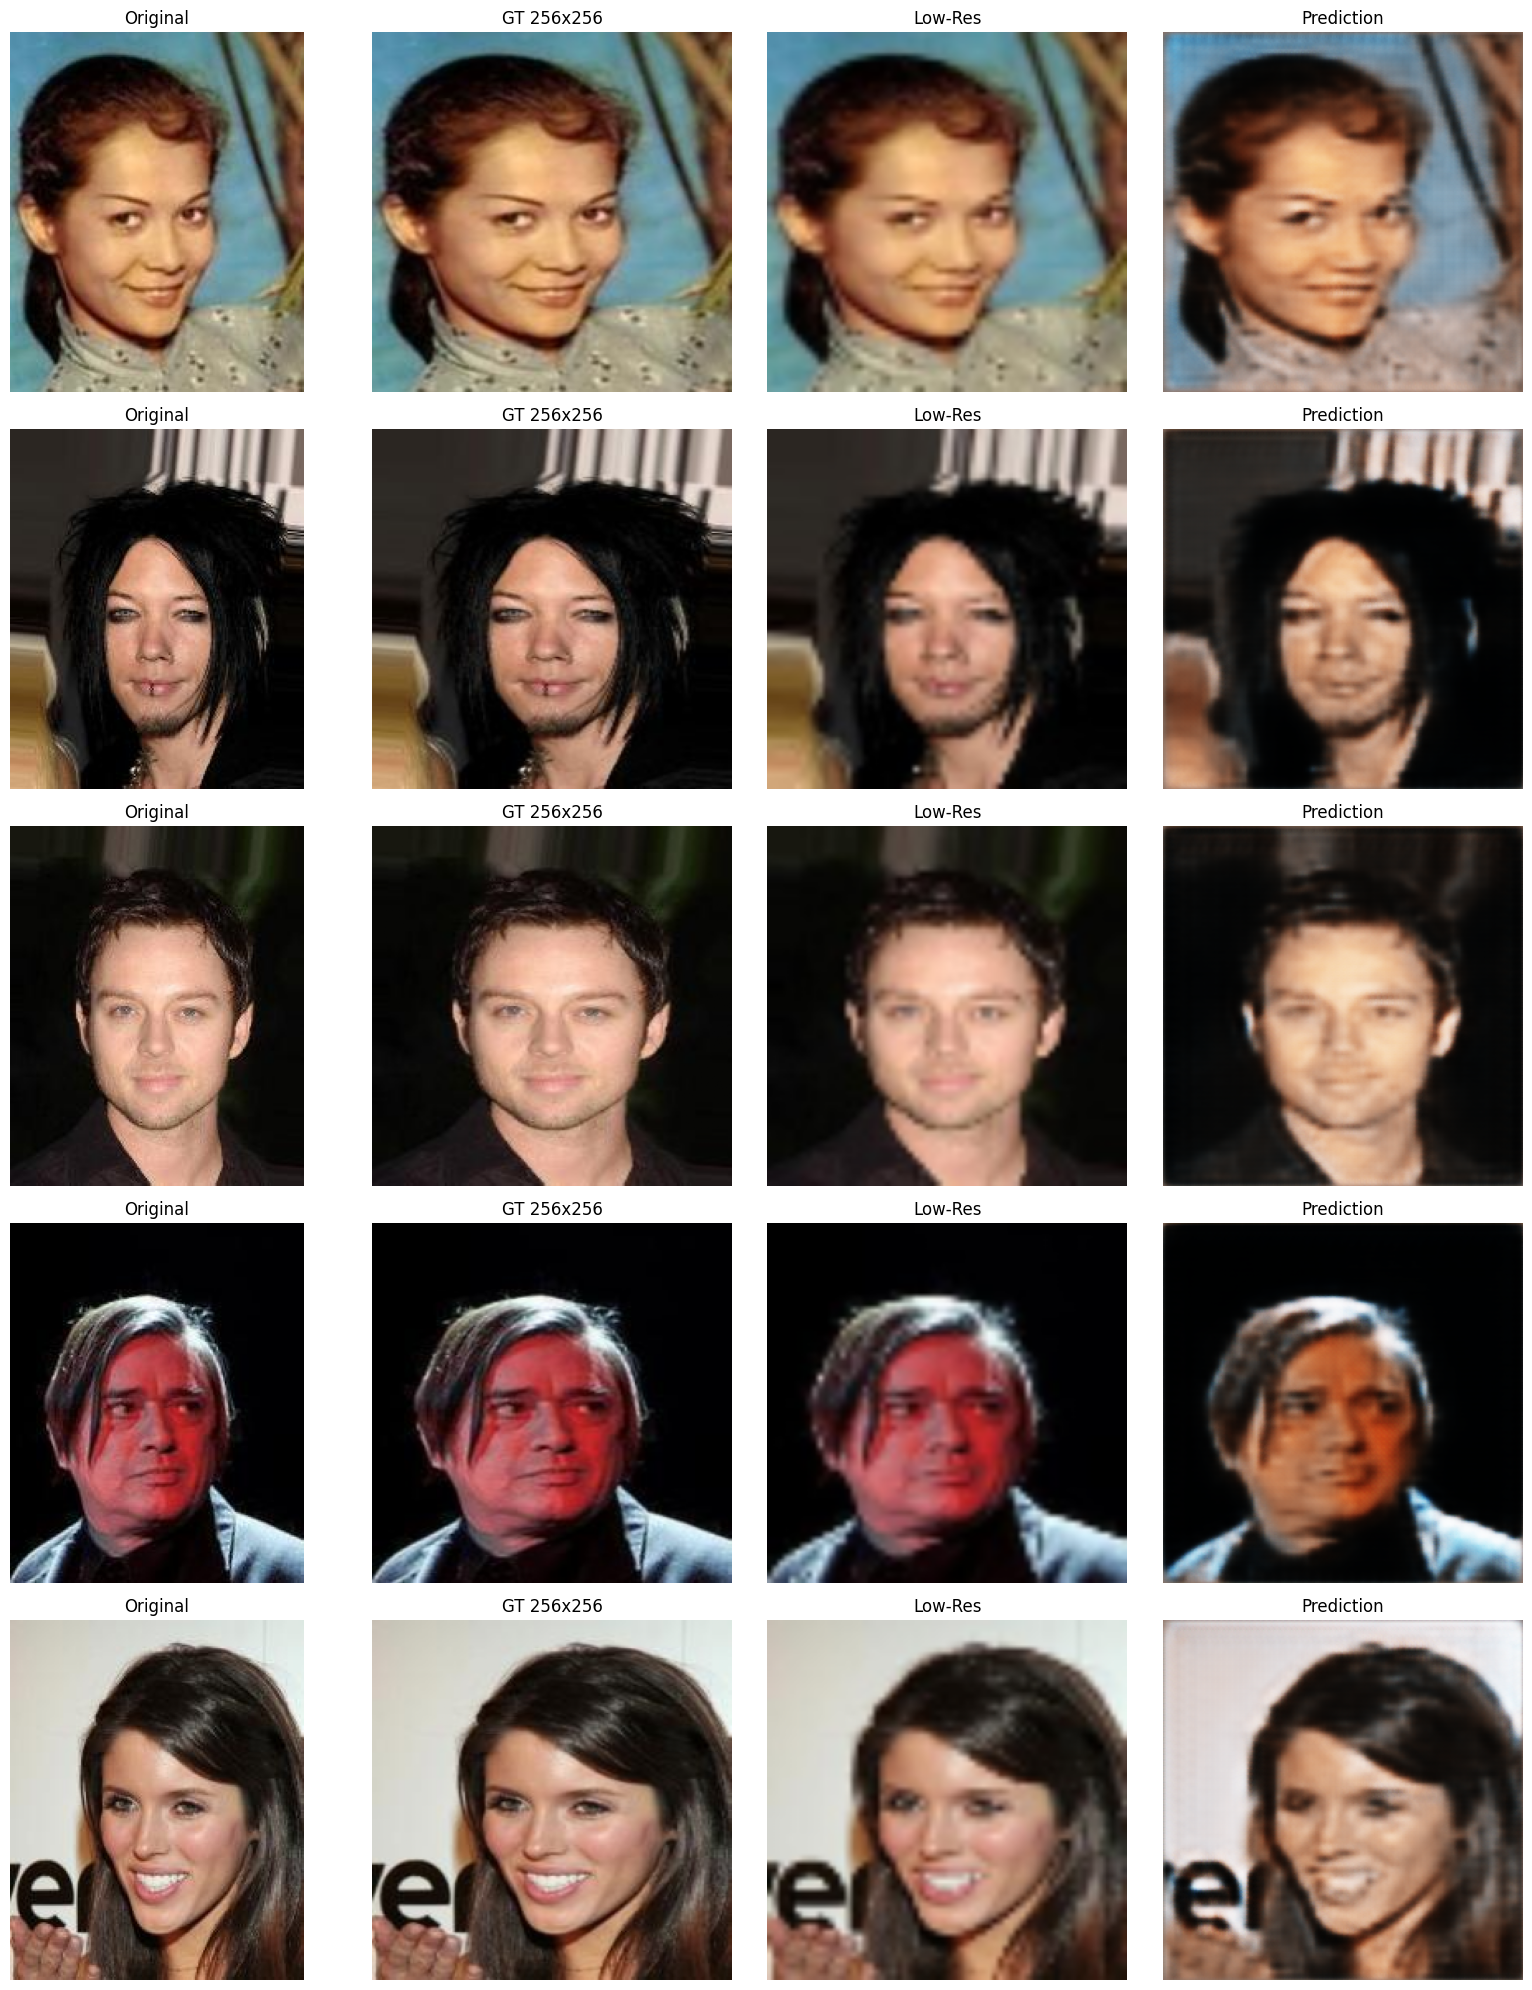

100/100 ━━━━━━━━━━━━━━━━━━━━ 24s 238ms/step - loss: 0.0398
Epoch 2/3
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step - loss: 0.0390

In [ ]:
import os, cv2 as cv, numpy as np, matplotlib.pyplot as plt, tensorflow as tf
from IPython.display import display, Image # Import display and Image

def show_and_save_samples(model, imgs, base_dir, epoch, n=5, save_dir='./epoch_samples'):
    os.makedirs(save_dir, exist_ok=True)
    chosen = np.random.choice(imgs, n, replace=False)
    fig, axes = plt.subplots(n, 4, figsize=(16, 4*n))
    if n == 1: axes = np.expand_dims(axes, 0)

    for i, fname in enumerate(chosen):
        path = os.path.join(base_dir, fname)
        rgb = cv.cvtColor(cv.imread(path), cv.COLOR_BGR2RGB)
        gt128 = cv.resize(rgb, (256,256)).astype('float32')/255
        img64 = cv.resize(rgb, (64,64)).astype('float32')/255
        pred  = model.predict(np.expand_dims(img64,0), verbose=0)[0]
        lowup = cv.resize((img64*255).astype(np.uint8),(256,256))

        for ax, im, title in zip(axes[i],[rgb,gt128,lowup,pred],
                                 ['Original','GT 256x256','Low-Res','Prediction']):
            ax.imshow(im); ax.set_title(title); ax.axis('off')

    plt.tight_layout(); plt.savefig(f"{save_dir}/epoch_{epoch+1:02d}.png"); plt.show()

# --- Simple Callbacks ---
def on_epoch_end(epoch, logs):
    show_and_save_samples(model, imgs, base_dir, epoch, n=5)
    model.save(f'./checkpoints/model_epoch_{epoch+1:02d}.keras')

show_cb = tf.keras.callbacks.LambdaCallback(on_epoch_end=on_epoch_end)


batch_size = 32
steps_per_epoch = len(imgs)//batch_size
base_dir = '/kaggle/input/celeba-dataset/img_align_celeba/img_align_celeba/'
os.makedirs('./checkpoints', exist_ok=True)

results = model.fit(
    datagen(batch_size=batch_size),
    steps_per_epoch=100,
    epochs=3,
    callbacks=[show_cb],
    verbose=1)

# Display the contents of the epoch_samples directory after training
print("\nContents of the epoch_samples directory:")
saved_images = os.listdir('./epoch_samples')
for filename in saved_images:
    print(filename)

# Load and display one of the saved images using IPython.display
if saved_images:
    sample_image_path = os.path.join('./epoch_samples', saved_images[0])
    print(f"\nDisplaying sample image: {saved_images[0]}")
    display(Image(filename=sample_image_path))

### 7. Project Summary

This notebook successfully implemented and trained a U-Net model for image super-resolution. The model was trained on the CelebA dataset, taking 64x64 images as input and generating 256x256 images.

The training process showed a decrease in the mean absolute error (MAE) loss over epochs, indicating that the model is learning to reconstruct higher-resolution images. The generated sample images at the end of each epoch provide a visual representation of the model's progress.

Further improvements could include:
- Experimenting with different loss functions (e.g., perceptual loss)
- Using a larger and more diverse dataset
- Implementing more advanced super-resolution techniques (e.g., Generative Adversarial Networks)
- Hyperparameter tuning to optimize model performance